# OCR_Printed and handwritten text extraction from images using Tesseract and Google Cloud Vision API


In [1]:
%reset -sf
from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from google.cloud import vision
import io

import warnings
warnings.simplefilter("ignore")

import os, cv2
os.chdir(r'D:\RAPID HACK')
         
fileList = [x for x in os.listdir() if 'jpeg'  in x.lower()]
fileList[:5]

['test_image.jpeg']

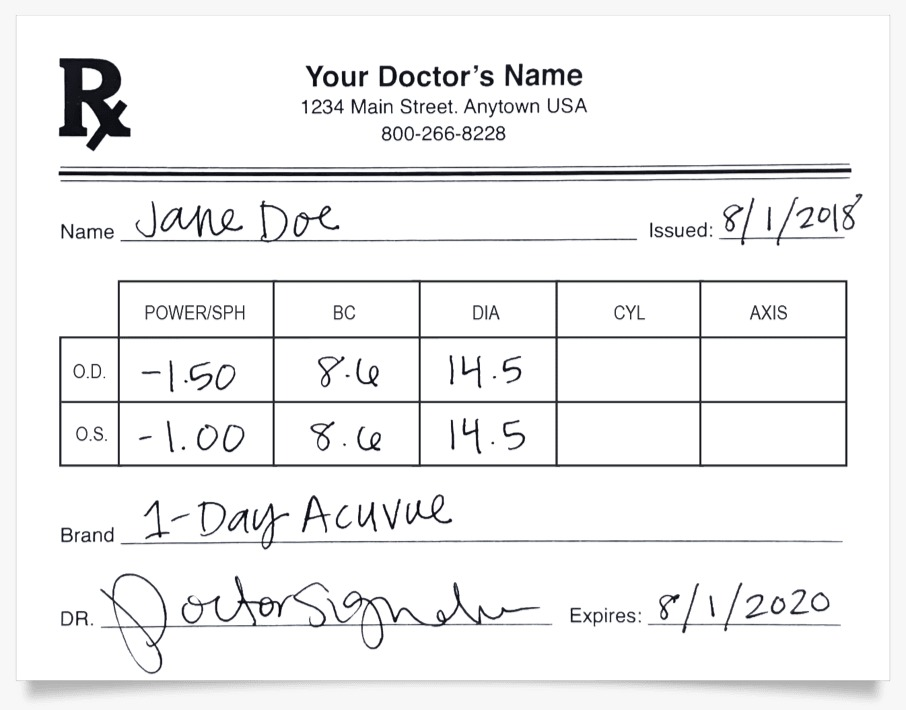

In [2]:
Image(filename = fileList[0], width = 300)

## Step 1. Page Segmentation

Use OpenCV to find lines between sections, and use the coordinates of the lines to break the image into segments.

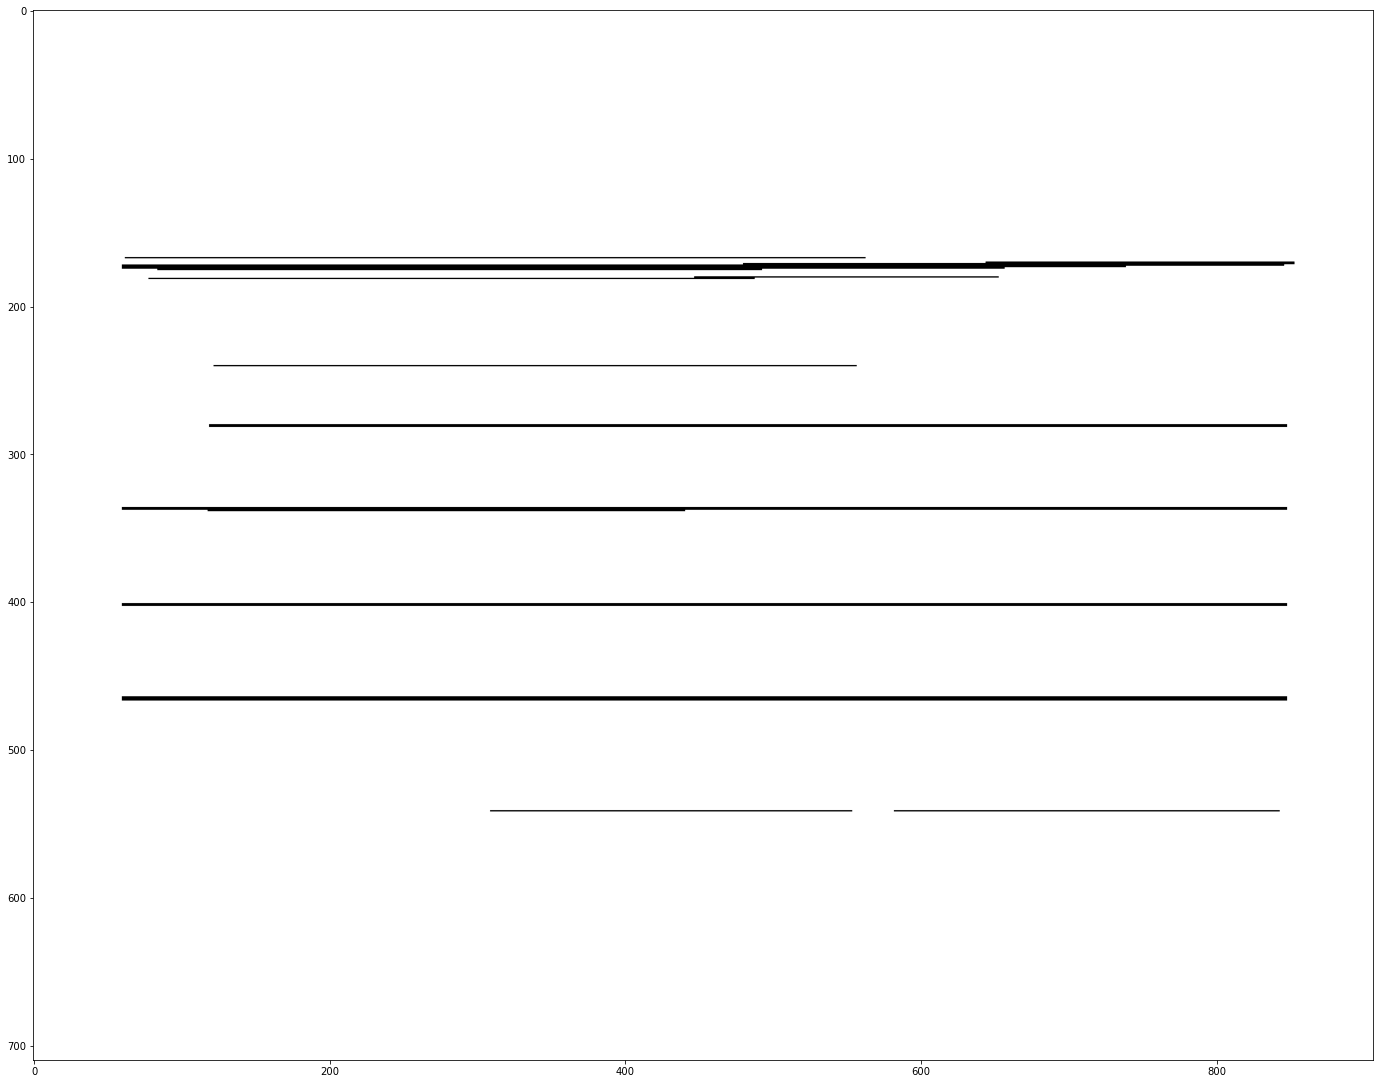

In [3]:
img = fileList[0]

def findHorizontalLines(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(img)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

In [4]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 0]

,rowLoc,LineLength
167,167,127755
170,170,53295
171,171,95115
172,172,200430
173,173,173145
174,174,152235
175,175,104295
180,180,52530
181,181,104550
240,240,110925


In [5]:
df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()

In [6]:
df_lineLocations.head()

,rowLoc,LineLength,line,cumSum
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,0,0,0
4,4,0,0,0


In [7]:
import pandasql as ps

query = '''
select row_number() over (order by cumSum) as SegmentOrder
, min(rowLoc) as SegmentStart
, max(rowLoc) - min(rowLoc) as Height
from df_lineLocations
where line = 0
--and CumSum !=0
group by cumSum
'''

df_SegmentLocations  = ps.sqldf(query, locals())
df_SegmentLocations

,SegmentOrder,SegmentStart,Height
0,1,0,166
1,2,168,1
2,3,176,3
3,4,182,57
4,5,241,38
5,6,282,53
6,7,339,61
7,8,403,60
8,9,467,73
9,10,542,167


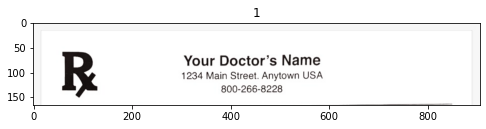

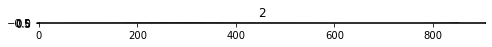

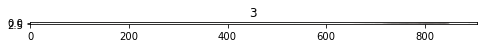

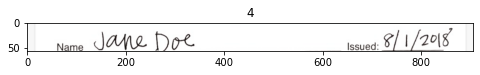

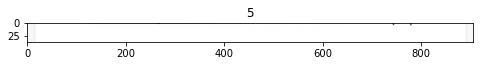

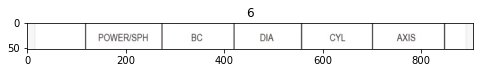

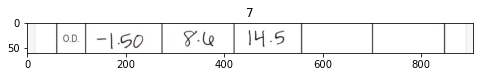

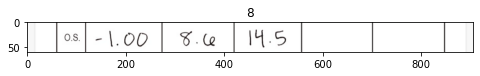

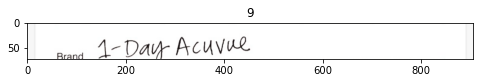

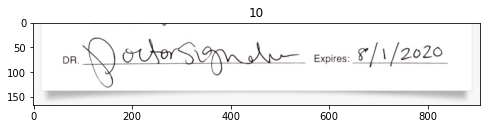

In [8]:
def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        plt.figure(figsize=(8,8))
        plt.imshow(cropped)
        plt.title(str(i+1))        

    return segments

img = fileList[0]
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

# Step 2. Extract Printed Text

In [11]:
# Extract text from image with two columns of contents
import re
import cv2
import pytesseract
from pytesseract import Output

# tell pytesseract where the engine is installed
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'


def extractTextFromImg(segment):
    text = pytesseract.image_to_string(segment, lang='eng')         
    text = text.encode("gbk", 'ignore').decode("gbk", "ignore")
        
    return text

In [12]:
segment = [segments[0],segments[3],segments[5],segments[6],segments[7],segments[8],segments[9]]

for seg in segment:
    segment = seg
    text = extractTextFromImg(segment)
    print(text)

Your Doctor’s Name
1234 Main Street. Anytown USA
800-266-8228

Name JAMZ Dow Issued: $/ 1/208

 

POWER/SPH |

BC

 

0D.

 

-|50 | -e | 14-5 |

 

Os.

 

-\.00 | %-@ | 14.5 |

~ A-Dauyp Acuver

 

oh) CUS gh Expires: /1 [2020



In [38]:
segment = segments[0]
text1 = extractTextFromImg(segment)
print("--------------Name and address of the doctor----------------")
print(text1)


segment1 = segments[3]
text2 = extractTextFromImg(segment1)
print("--------------first Name of patient----------------")
res = text2.split('Name', maxsplit=1)[-1]\
               .split(maxsplit=1)[0]
print(res)

print("--------------second Name of patient----------------")
res2 = text2.split('Name', maxsplit=1)[-1]\
               .split(maxsplit=2)[1]
print(res2)

print("-------------- issued on----------------")
keyword =":"
before_keyword, keyword, after_keyword = text2.partition(keyword)
after_keyword=after_keyword.replace("$","8")
print(after_keyword)

segment = segments[6]
text2 = extractTextFromImg(segment)
print("--------------Power ----------------")
print(text2)
segment = segments[7]
text3 = extractTextFromImg(segment)
print(text3)
print("--------------Brand----------------")
segment = segments[8]
text4 = extractTextFromImg(segment)
print(text4)



--------------Name and address of the doctor----------------
Your Doctor’s Name
1234 Main Street. Anytown USA
800-266-8228

--------------first Name of patient----------------
JAMZ
--------------second Name of patient----------------
Dow
-------------- issued on----------------
 8/ 1/208

--------------Power ----------------
 

0D.

 

-|50 | -e | 14-5 |

 

Os.

 

-\.00 | %-@ | 14.5 |

--------------Brand----------------
~ A-Dauyp Acuver



In [71]:

# Import pandas library
import pandas as pd
  
# initialize list of lists
data = [[text1,res,res2,after_keyword,text2,text3,text4]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Name and Address of Doctor','First Name of Patient','Second Name of Patient','Issued on','Power OD','Power OS','Brand'])
df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)
df.replace(to_replace=[r"%", ""], value=["",""], regex=True, inplace=True)
df.replace(to_replace=[r"@", ""], value=["",""], regex=True, inplace=True)
df.replace(to_replace=[r"~", ""], value=["",""], regex=True, inplace=True)


# print dataframe.
df


,Name and Address of Doctor,First Name of Patient,Second Name of Patient,Issued on,Power OD,Power OS,Brand
0,Your Doctor’s Name1234 Main Street. Anytown US...,JAMZ,Dow,8/ 1/208,0D. -|50 | -e | 14-5 |,Os. -\.00 | - | 14.5 |,A-Dauyp Acuver


In [72]:
df.to_csv('details.csv')
print("SAVED!!!!!")
df.head()

SAVED!!!!!


,Name and Address of Doctor,First Name of Patient,Second Name of Patient,Issued on,Power OD,Power OS,Brand
0,Your Doctor’s Name1234 Main Street. Anytown US...,JAMZ,Dow,8/ 1/208,0D. -|50 | -e | 14-5 |,Os. -\.00 | - | 14.5 |,A-Dauyp Acuver


In [75]:
original_data=pd.read_csv('original_data.csv')
pd.read_csv(io.StringIO(df.to_csv(index=False)))
original_data.head()


,Name and Address of Doctor,First Name of Patient,Second Name of Patient,Issued on,Power OD,Power OS,Brand
0,Your Doctor's Name1234 Main Street. Anytown US...,Jane,Doe,08-01-2018,0D. -1.50 | 8.4 | 14-5 |,Os. -1.00 | 8.4 | 14.5 |,1-Day Acuvue


In [80]:
x = df.merge(
    original_data,
    left_on=['Name and Address of Doctor','First Name of Patient','Second Name of Patient','Issued on','Power OD','Power OS','Brand'],
    right_on=['Name and Address of Doctor','First Name of Patient','Second Name of Patient','Issued on','Power OD','Power OS','Brand'],
    indicator=True,
    how="right",
)



In [81]:
errors = (
    x.loc[x._merge.eq("right_only")]
    .apply(lambda x: [x["Name and Address of Doctor"], x["First Name of Patient"],x["Second Name of Patient"],x["Issued on"],x["Power OD"],x["Power OS"],x["Brand"]], axis=1)
    .to_list()
)

print(errors)

[["Your Doctor's Name1234 Main Street. Anytown USA800-266-8228", 'Jane', 'Doe', '08-01-2018', ' 0D. -1.50 | 8.4 | 14-5 |', ' Os. -1.00 | 8.4 | 14.5 |', '1-Day Acuvue']]
